<a href="https://colab.research.google.com/github/puraminy/mini_proj3/blob/master/SOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install minisom

  Running setup.py bdist_wheel for minisom ... - done
  Stored in directory: /root/.cache/pip/wheels/4a/5c/75/d21b1b07292ccd8720a8076304f793031e016c16e9c8eacbf9
Successfully built minisom


#Import Alphabets Dataset

Cloning into 'SOM'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


((500, 784), (500,), 7, 0)

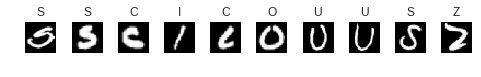

fatal: destination path 'SOM' already exists and is not an empty directory.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


((500, 784), (500,), 7, 0)

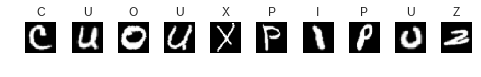

In [2]:
#!git clone "https://github.com/puraminy/mini_proj3"
!git clone "https://github.com/Benyaminhosseiny/SOM"

import numpy as np
alphabet = np.load('SOM/Alphabets.npy')
label = np.load('SOM/Alphabet_labels.npy')
label2 = ['C', 'I', 'O', 'P', 'S', 'U', 'X', 'Z']


import matplotlib.pyplot as plt
idx = np.random.randint(499, size=10)

fig, axes = plt.subplots(1, 10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=None, wspace=0.5)

# for i in range(len(alphabet)):
#   alphabet[i] = alphabet[i] * (255.0 / alphabet[i].max())

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
alphabet = sc.fit_transform(alphabet)
  
pltalpha = alphabet[idx,:]
pltlbl = label[idx]

for i in range(10):
  axes[i].imshow(-1*np.reshape(pltalpha[i,:],[28,28]))
  axes[i].axis('off')
  xlabel = label2[pltlbl[i]]; axes[i].set_title(xlabel)



alphabet.shape, label.shape, max(label), min(label)


In [0]:
# This code added by Ahmad Pouramini

print(alphabet[1].shape)

from minisom import MiniSom

som = MiniSom(x=784, y=1, input_len=28*28, sigma=1.0, learning_rate=1.0, neighborhood_function='triangle')  # initialization of 25x25 SOM
som.random_weights_init(alphabet)  # initialize weights with random values 
som.train_random(alphabet, 300)




plt.figure(figsize=(10, 10))

from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som.distance_map().T)
colorbar()

for x, t in zip(alphabet, label):  # scatterplot
    w = som.winner(x)
    #print("winner=", w, " label:" , label2[t])
    plt. text(w[0]+.5,
              w[1]+.5,
              label2[t],
              color=plt.cm.rainbow(t / 7.),
              fontdict={'weight': 'bold',  'size': 11}
              )

mappings = som.win_map(alphabet)
print(len(mappings))
print(np.shape(som._weights))

#SOM

In [0]:
# SOM Training
from minisom import MiniSom

def SOM (data = alphabet, x = 25, y = 25, features = 28*28, radius = 0, learningrate = 1, decay = 0.9, neighborhood='gaussian', ini_weights = np.random.random([x,y,features])):
    # initial weights
    
    weights = ini_weights
    delta_w = 1
    i=1
    while delta_w>0.0001:
        som = MiniSom(x=x, y=y, input_len=features, sigma=0.0, learning_rate=learningrate,
                      neighborhood_function=neighborhood)  # initialization of 25x25 SOM
        som._weights = weights-0
        #weights = som.get_weights() - 0
        som.train_random(data, 1)  # trains the SOM with 1 epoch
        #som.train_batch(data, 1)
        learningrate = decay * learningrate - 0
        delta_w = np.max(np.abs(weights-som._weights))
        weights = som._weights - 0
        i=i+1
    return som, i, delta_w, weights

##Constant Parameters

In [0]:
features = 28*28
learningrate = 0.9
decay = 0.9
x=625
y=1
# ini_weights (1) PCA
#som0 = MiniSom(x=x, y=y, input_len=features, sigma=radius, learning_rate=learningrate, neighborhood_function=neighborhood)  # initialization of 25x25 SOM
#som0.pca_weights_init(alphabet)
#ini_weights = som0._weights - 0

# ini_weights (2) Distribute from min to max value of input data [0:1]    
#ini_weights = np.expand_dims(np.linspace(0, 1, x*y),axis=1)*np.ones([1,features])
#ini_weights = np.reshape(ini_weights, [x, y, features])

# ini_weights (3) Input mean values    
#ini_weights = np.expand_dims(np.mean(alphabet,axis=0),axis=1)*np.ones([1,x*y])
#ini_weights = np.reshape(weights, [x, y, features])

# ini_weights (4) Random
ini_weights = np.random.random([x,y,features])

# ini_weights (5) Zeros
#ini_weights = np.zeros([x,y,features])

# ini_weights (6) Ones
#ini_weights = np.ones([x,y,features])

#Part A

In [0]:
x = 625; y = 1
ini_weights = np.reshape(ini_weights,[x,y,features])
radius = 0

#neighborhood='mexican_hat'
#neighborhood='bubble'
#neighborhood='gaussian'
neighborhood='triangle'

somA,ii,delta_w, weights = SOM (data = alphabet, x = x, y = y, features = features, radius = radius,
                    learningrate = learningrate, decay = decay, neighborhood=neighborhood, ini_weights = ini_weights)
#weights = som.get_weights() - 0

# Visualizing Results
if x>1 and y>1:
    plt.figure(figsize=(8, 8))
    wmap = {}
    im = 0
    for x, t in zip(alphabet, label):  # scatterplot
        w = somA.winner(x)
        wmap[w] = im
        plt. text(w[0]+.5,
                  w[1]+.5,
                  label2[t],
                  color=plt.cm.rainbow(t / 7.),
                  fontdict={'weight': 'bold',  'size': 11}
                  )
        im = im + 1
    plt.axis([0, weights.shape[0], 0,  weights.shape[1]])
    #plt.savefig('resulting_images/som_digts.png')
    plt.show()


mappings = somA.win_map(alphabet)
print(len(mappings))
nodes = list(mappings) # position of nodes that contain values!
values = []
for i in nodes:
    values.append(mappings[i])
sorted_values = sorted(values, key=len)

if len(mappings)>19:
  selected_nodes = sorted_values[-20:] # 20 nodes with the most data
  result_mat =np.zeros([20,9])
  for i in range(20):
      result_mat[i,8] = len(selected_nodes[i])
      for j in range(len(selected_nodes[i])):
          zeroo = alphabet-selected_nodes[i][j]
          pos = np.where(~zeroo.any(axis=1))[0]
          result_mat[i, label[pos]] = result_mat[i, label[pos]]+1
          
else:
  selected_nodes = sorted_values
  result_mat =np.zeros([len(mappings),9])
  for i in range(len(mappings)):
      result_mat[i,8] = len(selected_nodes[i])
      for j in range(len(selected_nodes[i])):
          zeroo = alphabet-selected_nodes[i][j]
          pos = np.where(~zeroo.any(axis=1))[0]
          result_mat[i, label[pos]] = result_mat[i, label[pos]]+1



import seaborn as sn
import pandas  as pd

df_result = pd.DataFrame(result_mat, range(result_mat.shape[0]), range(9))

aylabels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10','11',
            '12', '13', '14', '15', '16', '17', '18', '19', '20']
axlabels = ['C', 'I', 'O', 'P', 'S', 'U', 'X', 'Z', 'Total']

plt.figure(figsize=(10, 7))
sn.set(font_scale=1.4)  # for label size
sn.heatmap(df_result, annot=True, annot_kws={"size": 12}, xticklabels=axlabels, yticklabels=aylabels)  # font size
plt.show()

print("Convergence in "+str(ii)+" iterations")

#Part B

In [0]:
x = 625; y = 1
ini_weights = np.reshape(ini_weights,[x,y,features])
radius = 1

#neighborhood='mexican_hat'
#neighborhood='bubble'
#neighborhood='gaussian'
neighborhood='triangle'

somB,ii,delta_w, weights = SOM (data = alphabet, x = x, y = y, features = features, radius = radius,
                    learningrate = learningrate, decay = decay, neighborhood=neighborhood, ini_weights = ini_weights)
#weights = som.get_weights() - 0

# Visualizing Results
if x>1 and y>1:
    plt.figure(figsize=(8, 8))
    wmap = {}
    im = 0
    for x, t in zip(alphabet, label):  # scatterplot
        w = somB.winner(x)
        wmap[w] = im
        plt. text(w[0]+.5,
                  w[1]+.5,
                  label2[t],
                  color=plt.cm.rainbow(t / 7.),
                  fontdict={'weight': 'bold',  'size': 11}
                  )
        im = im + 1
    plt.axis([0, weights.shape[0], 0,  weights.shape[1]])
    #plt.savefig('resulting_images/som_digts.png')
    plt.show()


mappings = somB.win_map(alphabet)
print(len(mappings))
nodes = list(mappings) # position of nodes that contain values!
values = []
for i in nodes:
    values.append(mappings[i])
sorted_values = sorted(values, key=len)

if len(mappings)>19:
  selected_nodes = sorted_values[-20:] # 20 nodes with the most data
  result_mat =np.zeros([20,9])
  for i in range(20):
      result_mat[i,8] = len(selected_nodes[i])
      for j in range(len(selected_nodes[i])):
          zeroo = alphabet-selected_nodes[i][j]
          pos = np.where(~zeroo.any(axis=1))[0]
          result_mat[i, label[pos]] = result_mat[i, label[pos]]+1
          
else:
  selected_nodes = sorted_values
  result_mat =np.zeros([len(mappings),9])
  for i in range(len(mappings)):
      result_mat[i,8] = len(selected_nodes[i])
      for j in range(len(selected_nodes[i])):
          zeroo = alphabet-selected_nodes[i][j]
          pos = np.where(~zeroo.any(axis=1))[0]
          result_mat[i, label[pos]] = result_mat[i, label[pos]]+1



import seaborn as sn
import pandas  as pd

df_result = pd.DataFrame(result_mat, range(result_mat.shape[0]), range(9))

aylabels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10','11',
            '12', '13', '14', '15', '16', '17', '18', '19', '20']
axlabels = ['C', 'I', 'O', 'P', 'S', 'U', 'X', 'Z', 'Total']

plt.figure(figsize=(10, 7))
sn.set(font_scale=1.4)  # for label size
sn.heatmap(df_result, annot=True, annot_kws={"size": 12}, xticklabels=axlabels, yticklabels=aylabels)  # font size
plt.show()

print("Convergence in "+str(ii)+" iterations")

#Part C

In [0]:
x = 25; y = 25
ini_weights = np.reshape(ini_weights,[x,y,features])
radius = 1

#neighborhood='mexican_hat'
#neighborhood='bubble'
#neighborhood='gaussian'
neighborhood='triangle'

somC,ii,delta_w, weights = SOM (data = alphabet, x = x, y = y, features = features, radius = radius,
                    learningrate = learningrate, decay = decay, neighborhood=neighborhood, ini_weights = ini_weights)
#weights = som.get_weights() - 0

# Visualizing Results
if x>1 and y>1:
    plt.figure(figsize=(8, 8))
    wmap = {}
    im = 0
    for x, t in zip(alphabet, label):  # scatterplot
        w = somC.winner(x)
        wmap[w] = im
        plt. text(w[0]+.5,
                  w[1]+.5,
                  label2[t],
                  color=plt.cm.rainbow(t / 7.),
                  fontdict={'weight': 'bold',  'size': 11}
                  )
        im = im + 1
    plt.axis([0, weights.shape[0], 0,  weights.shape[1]])
    #plt.savefig('resulting_images/som_digts.png')
    plt.show()


mappings = somC.win_map(alphabet)
print(len(mappings))
nodes = list(mappings) # position of nodes that contain values!
values = []
for i in nodes:
    values.append(mappings[i])
sorted_values = sorted(values, key=len)

if len(mappings)>19:
  selected_nodes = sorted_values[-20:] # 20 nodes with the most data
  result_mat =np.zeros([20,9])
  for i in range(20):
      result_mat[i,8] = len(selected_nodes[i])
      for j in range(len(selected_nodes[i])):
          zeroo = alphabet-selected_nodes[i][j]
          pos = np.where(~zeroo.any(axis=1))[0]
          result_mat[i, label[pos]] = result_mat[i, label[pos]]+1
          
else:
  selected_nodes = sorted_values
  result_mat =np.zeros([len(mappings),9])
  for i in range(len(mappings)):
      result_mat[i,8] = len(selected_nodes[i])
      for j in range(len(selected_nodes[i])):
          zeroo = alphabet-selected_nodes[i][j]
          pos = np.where(~zeroo.any(axis=1))[0]
          result_mat[i, label[pos]] = result_mat[i, label[pos]]+1



import seaborn as sn
import pandas  as pd

df_result = pd.DataFrame(result_mat, range(result_mat.shape[0]), range(9))

aylabels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10','11',
            '12', '13', '14', '15', '16', '17', '18', '19', '20']
axlabels = ['C', 'I', 'O', 'P', 'S', 'U', 'X', 'Z', 'Total']

plt.figure(figsize=(10, 7))
sn.set(font_scale=1.4)  # for label size
sn.heatmap(df_result, annot=True, annot_kws={"size": 12}, xticklabels=axlabels, yticklabels=aylabels)  # font size
plt.show()

print("Convergence in "+str(ii)+" iterations")